<a href="https://colab.research.google.com/github/ZettaDcode/MLPractice/blob/main/Carpeta1/Predicci%C3%B3nGastosOnline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
El trabajo final consiste en realizar procesamiento de datos usando Apache Spark. Se debe realizar únicamente una presentación oral (de todos los miembros del grupo) y se debe subir aquí las diapositivas (en ppt o pdf).

Las partes que debe contener el trabajo son las siguientes:

[2 puntos] Introducción. Debe contener información sobre el contexto de los datos, de dónde fueron obtenidos, y su potencial importancia
[4 puntos] Descripción de las variables. Se debe especificar qué representa cada variable, su importancia dentro del conjunto de datos, qué rangos tienen (valores máximos, mínimos), qué tipo de datos son (cuantitativos, cualitativos)
[6 puntos] Análisis descriptivo. Se debe usar Spark SQL o Spark RDD. Se debe incluir al menos 10 operaciones que brinden información descriptiva como estadísticas generales, estadísticas por datos agrupados, análisis por fechas, etc. Además, se debe incluir algunas figuras que muestren resultados que se considere importantes.
[6 puntos] Análisis predictivo. Se debe utilizar Spark MLlib. Se debe incluir al menos 2 algoritmos para resolver algún problema de regresión, clasificación o clusterización, según corresponda. Se debe, además, analizar los resultados con las métricas correspondientes
[2 puntos] Conclusiones

In [ ]:
#CREACION DE UNA SESION SPARKSQL
!pip install -q pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


LECTURA DE DATOS

In [ ]:
ruta_archivo = "/content/drive/MyDrive/Colab Notebooks/PGVD/shoppingDataSet.csv"
# Cargar los datos
df = spark.read.load(ruta_archivo,
                     format="csv", sep=";",
                     inferSchema="true", header="true")

In [ ]:
df.printSchema()# Esquema de los datos

root
 |-- _c0: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Tenure_Months: integer (nullable = true)
 |-- Transaction_ID: integer (nullable = true)
 |-- Transaction_Date: timestamp (nullable = true)
 |-- Product_SKU: string (nullable = true)
 |-- Product_Description: string (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Avg_Price: double (nullable = true)
 |-- Delivery_Charges: double (nullable = true)
 |-- Coupon_Status: string (nullable = true)
 |-- GST: double (nullable = true)
 |-- Date: string (nullable = true)
 |-- Offline_Spend: integer (nullable = true)
 |-- Online_Spend: double (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Coupon_Code: string (nullable = true)
 |-- Discount_pct: integer (nullable = true)



In [ ]:
df.show(5)# Mostrar las 5 primeras filas

+---+----------+------+--------+-------------+--------------+-------------------+--------------+--------------------+----------------+--------+---------+----------------+-------------+---+--------+-------------+------------+-----+-----------+------------+
|_c0|CustomerID|Gender|Location|Tenure_Months|Transaction_ID|   Transaction_Date|   Product_SKU| Product_Description|Product_Category|Quantity|Avg_Price|Delivery_Charges|Coupon_Status|GST|    Date|Offline_Spend|Online_Spend|Month|Coupon_Code|Discount_pct|
+---+----------+------+--------+-------------+--------------+-------------------+--------------+--------------------+----------------+--------+---------+----------------+-------------+---+--------+-------------+------------+-----+-----------+------------+
|  0|     17850|     M| Chicago|           12|         16679|2019-01-01 00:00:00|GGOENEBJ079499|Nest Learning The...|        Nest-USA|       1|   153.71|             6.5|         Used|0.1|1/1/2019|         4500|      2424.5|    1|  

In [ ]:
from pyspark.sql.functions import col, to_date
#Conversion Date: String a fecha
df = df.withColumn('Date', to_date(col('Date'), 'dd/MM/yyyy'))

In [ ]:
df.printSchema()# Esquema de los datos

root
 |-- _c0: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Tenure_Months: integer (nullable = true)
 |-- Transaction_ID: integer (nullable = true)
 |-- Transaction_Date: timestamp (nullable = true)
 |-- Product_SKU: string (nullable = true)
 |-- Product_Description: string (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Avg_Price: double (nullable = true)
 |-- Delivery_Charges: double (nullable = true)
 |-- Coupon_Status: string (nullable = true)
 |-- GST: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- Offline_Spend: integer (nullable = true)
 |-- Online_Spend: double (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Coupon_Code: string (nullable = true)
 |-- Discount_pct: integer (nullable = true)



ANALISIS DESCRIPTIVO

In [ ]:
 # Estadísticas generales para columnas numéricas
df.describe(['Tenure_Months', 'Quantity', 'Avg_Price', 'Offline_Spend', 'Online_Spend']).show()

+-------+------------------+------------------+-----------------+------------------+------------------+
|summary|     Tenure_Months|          Quantity|        Avg_Price|     Offline_Spend|      Online_Spend|
+-------+------------------+------------------+-----------------+------------------+------------------+
|  count|             52924|             52924|            52924|             52924|             52924|
|   mean|26.127994860554757| 4.497638122590885|52.23764643639694|2830.9141410324237|1893.1091191142566|
| stddev|13.478285194132173|20.104710824270473|64.00688159847154| 936.1542466985863| 807.0140919655919|
|    min|                 2|                 1|             0.39|               500|            320.25|
|    max|                50|               900|           355.74|              5000|           4556.93|
+-------+------------------+------------------+-----------------+------------------+------------------+



In [ ]:
# Estadísticas agrupadas por género
df.groupBy('Gender').agg({'Quantity': 'mean', 'Avg_Price': 'mean'}).show()

+------+-----------------+------------------+
|Gender|    avg(Quantity)|    avg(Avg_Price)|
+------+-----------------+------------------+
|     F|  4.6042051686006|51.613536825519645|
|     M|4.321032283978511|53.271938042876336|
|  NULL|             NULL|              NULL|
+------+-----------------+------------------+



In [ ]:
# Total de gasto offline y online
df.groupBy('Gender').sum('Offline_Spend', 'Online_Spend').show()


+------+------------------+-------------------+
|Gender|sum(Offline_Spend)|  sum(Online_Spend)|
+------+------------------+-------------------+
|     F|          94474600|6.270691647000035E7|
|     M|          55348700|3.748399055000015E7|
|  NULL|              NULL|               NULL|
+------+------------------+-------------------+



In [ ]:
# Conteo de transacciones por mes
df.groupBy('Month').count().show()


+-----+-----+
|Month|count|
+-----+-----+
|   12| 4506|
|    1| 4065|
|    6| 4195|
|    3| 4348|
|    5| 4574|
|    9| 4290|
|    4| 4152|
|    8| 6151|
|   11| 3967|
|    2| 3287|
|    7| 5253|
|   10| 4167|
+-----+-----+



In [ ]:
# Gasto promedio por mes
df.groupBy('Month').agg({'Offline_Spend': 'mean', 'Online_Spend': 'mean'}).show()


+-----+------------------+------------------+
|Month|avg(Offline_Spend)| avg(Online_Spend)|
+-----+------------------+------------------+
|   12|3936.0284318080853| 2497.645937361215|
|    1| 3043.539256706867|1891.9210361801668|
|    6|2668.4951108991177|1773.5281969949908|
|    3|2413.3686148182237|1602.6876000920104|
|    5|  2176.61854768154|1656.6100218722395|
|    9|2772.0382462686566|1719.0126725746304|
|    4| 3243.132530120482|1975.1619590361624|
|    8| 2737.317073170732|1878.2493934959616|
|   11|3070.3105276445344|2255.6929285534056|
|    2|2887.1498172959805|1936.7040347137258|
|    7|2202.0567510950295|1724.6113902113989|
|   10| 3055.355427473583|1876.5063376560768|
+-----+------------------+------------------+



In [ ]:
# Gasto promedio por ubicacion
df.groupBy('Location').agg({'Offline_Spend': 'mean', 'Online_Spend': 'mean'}).show()

+-------------+------------------+------------------+
|     Location|avg(Offline_Spend)| avg(Online_Spend)|
+-------------+------------------+------------------+
|      Chicago|2845.8487486398258|1877.4937687704041|
|   New Jersey|  2741.63890739507|1911.1772795913594|
|Washington DC| 2785.029282576867| 1847.499619326512|
|   California|2919.9615765989092|1885.1791509668024|
|     New York| 2724.944061577016|1934.1197995166813|
|         NULL|              NULL|              NULL|
+-------------+------------------+------------------+



In [ ]:
# Conteo de transacciones con cupón
df.filter(col('Coupon_Status') == 'Used').count()


17904

In [ ]:
# Promedio de descuento por categoría de producto
df.groupBy('Product_Category').agg({'Discount_pct': 'mean'}).show()


+--------------------+------------------+
|    Product_Category| avg(Discount_pct)|
+--------------------+------------------+
|          Housewares|             19.04|
|           Backpacks|              NULL|
|              Office|19.709811146936897|
|                Waze|20.379061371841154|
|            Nest-USA| 19.87226147149076|
|                Bags|19.766206163655685|
|             Apparel|20.042480414873662|
|             Bottles| 19.62962962962963|
|           More Bags|              NULL|
|            Headgear|19.610894941634243|
|              Google|              NULL|
|         Accessories| 20.72340425531915|
|           Lifestyle| 19.26908150064683|
|         Nest-Canada|19.810725552050474|
|Notebooks & Journals|18.533333333333335|
|                Nest|22.480725623582767|
|                 Fun|              NULL|
|             Android|20.638297872340427|
|           Drinkware| 19.87367212173414|
|          Gift Cards|             16.25|
+--------------------+------------

In [ ]:
# Total de descuento por categoría de producto
df.groupBy('Product_Category').agg({'Discount_pct': 'sum'}).show()

+--------------------+-----------------+
|    Product_Category|sum(Discount_pct)|
+--------------------+-----------------+
|          Housewares|             2380|
|           Backpacks|             NULL|
|              Office|           128370|
|                Waze|            11290|
|            Nest-USA|           278470|
|                Bags|            37200|
|             Apparel|           363290|
|             Bottles|             5300|
|           More Bags|             NULL|
|            Headgear|            15120|
|              Google|             NULL|
|         Accessories|             4870|
|           Lifestyle|            59580|
|         Nest-Canada|             6280|
|Notebooks & Journals|            13900|
|                Nest|            49570|
|                 Fun|             NULL|
|             Android|              970|
|           Drinkware|            69220|
|          Gift Cards|             2600|
+--------------------+-----------------+
only showing top

In [ ]:
# total de descuento por mes
df.groupBy('month').agg({'Discount_pct': 'sum'}).orderBy('month', ascending=False).show()

+-----+-----------------+
|month|sum(Discount_pct)|
+-----+-----------------+
|   12|           135180|
|   11|            79260|
|   10|            41560|
|    9|           128250|
|    8|           122260|
|    7|            51980|
|    6|           124830|
|    5|            90360|
|    4|            41000|
|    3|           128760|
|    2|            64960|
|    1|            40250|
+-----+-----------------+



In [ ]:
# Top 5 productos más vendidos
df.groupBy('Product_SKU', 'Product_Description').agg({'Quantity': 'sum'}).orderBy('sum(Quantity)', ascending=False).show(5)


+--------------+--------------------+-------------+
|   Product_SKU| Product_Description|sum(Quantity)|
+--------------+--------------------+-------------+
|GGOEGGOA017399|            Maze Pen|        16234|
|GGOEGDHC018299|Google 22 oz Wate...|         9728|
|GGOEGBMJ013399|           Sport Bag|         7321|
|GGOEGOLC014299|Google Metallic N...|         6496|
|GGOEGFKQ020399|Google Laptop and...|         5847|
+--------------+--------------------+-------------+
only showing top 5 rows



In [ ]:
# Gasto promedio por cliente
df.groupBy('CustomerID').agg({'Offline_Spend': 'mean', 'Online_Spend': 'mean'}).show()


+----------+------------------+------------------+
|CustomerID|avg(Offline_Spend)| avg(Online_Spend)|
+----------+------------------+------------------+
|     17420|            4500.0|           3480.36|
|     17389| 2588.235294117647|1765.1252941176467|
|     15727|2838.3838383838383|1594.1575757575797|
|     16503|1603.7735849056603|           1473.55|
|     15447|            3000.0|           2117.28|
|     16861|            2000.0|           2435.12|
|     15100|3083.3333333333335|1935.7416666666668|
|     16916|            1000.0|1356.5899999999983|
|     12471|        2933.59375| 2163.094531249998|
|     12626| 2664.179104477612|1541.2407462686567|
|     14514|            2500.0|1941.3799999999997|
|     16500|            2500.0|           1094.77|
|     15738|2270.2702702702704|1187.2267567567567|
|     17809| 953.3333333333334| 2301.205333333333|
|     12393| 3431.818181818182| 3072.074999999999|
|     16791|            2500.0|1528.1000000000004|
|     17044|            3000.0|

In [ ]:
# Moda para una columna categórica
moda_gender = df.groupBy('Gender').agg(F.max(F.count('Gender'))).show()


NameError: ignored

In [ ]:
# Percentiles para una columna numérica
percentiles_quantity = df.approxQuantile('Quantity', [0.25, 0.5, 0.75], 0.01)


In [ ]:
# Cálculo del IQR para una columna numérica
Q1 = df.approxQuantile('Quantity', 0.25, 0.01)
Q3 = df.approxQuantile('Quantity', 0.75, 0.01)
IQR = Q3 - Q1


PySparkTypeError: ignored

In [ ]:
# Cálculo del coeficiente de variación para una columna numérica
cv_quantity = (F.stddev('Quantity') / F.avg('Quantity')).alias('CV_Quantity')
df.select(cv_quantity).show()


NameError: ignored

In [ ]:
# Correlación entre dos columnas numéricas
correlation = df.corr('Offline_Spend', 'Online_Spend')

In [ ]:
# Frecuencia de categorías para una columna categórica
freq_product_category = df.groupBy('Product_Category').count().show()


+--------------------+-----+
|    Product_Category|count|
+--------------------+-----+
|          Housewares|  125|
|           Backpacks|   89|
|              Office| 6513|
|                Waze|  554|
|            Nest-USA|14013|
|                Bags| 1882|
|             Apparel|18126|
|             Bottles|  270|
|           More Bags|   46|
|            Headgear|  771|
|              Google|  105|
|         Accessories|  235|
|           Lifestyle| 3092|
|         Nest-Canada|  317|
|Notebooks & Journals|  750|
|                Nest| 2205|
|                 Fun|  160|
|             Android|   47|
|           Drinkware| 3483|
|          Gift Cards|  160|
+--------------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date

# Configurar sesión de Spark
spark = SparkSession.builder.appName("Ejemplo").getOrCreate()

# Configurar la propiedad para usar el antiguo analizador de fechas
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Convertir la columna 'Date' al formato de fecha
df = df.withColumn('Date', to_date(col('Date'), 'dd/MM/yyyy'))


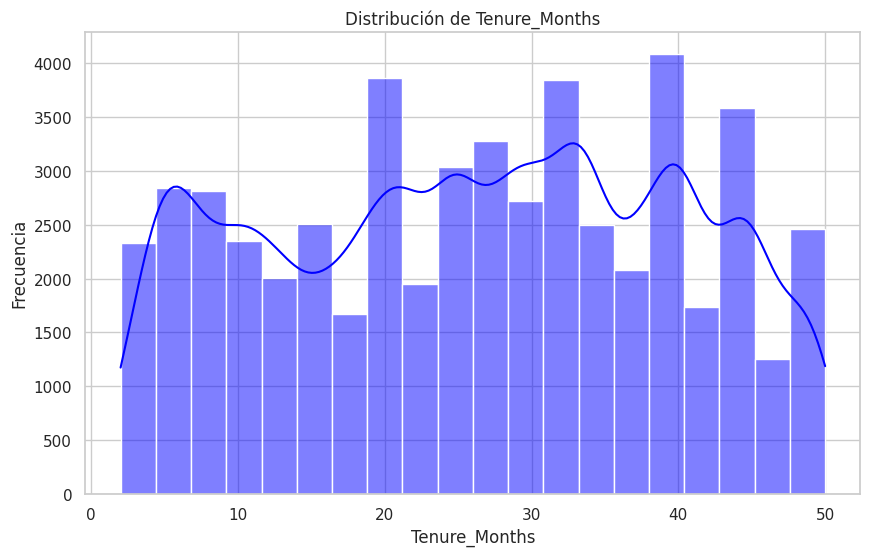

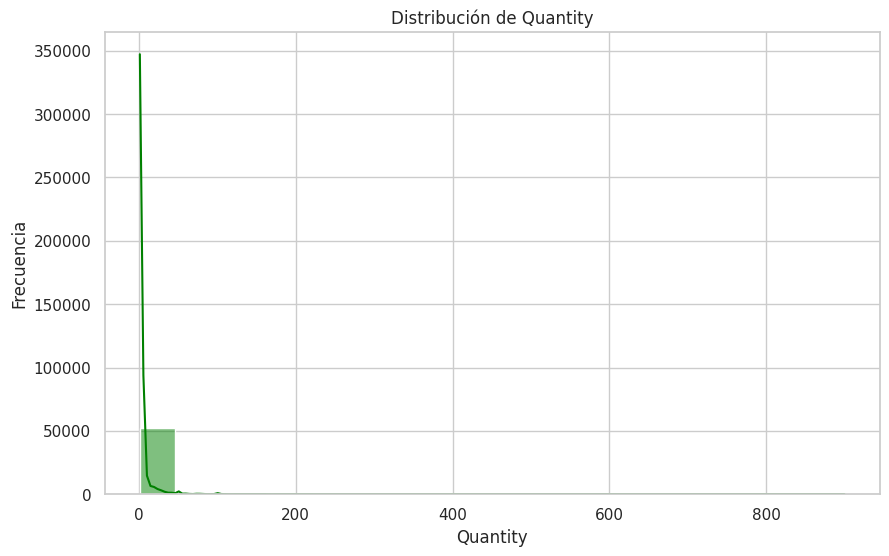

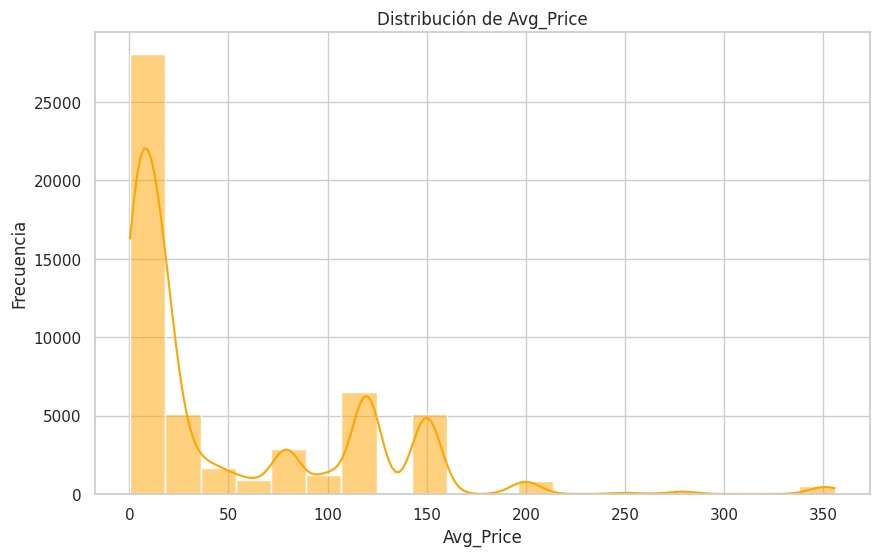

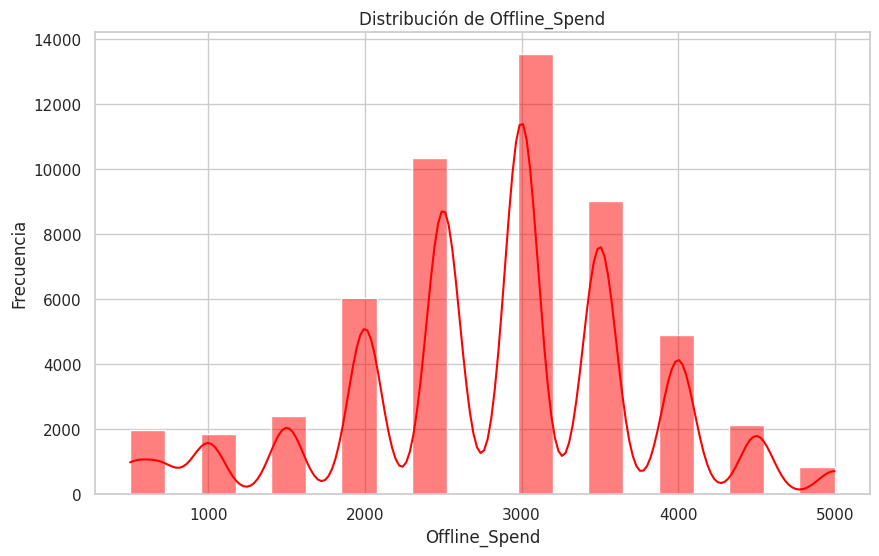

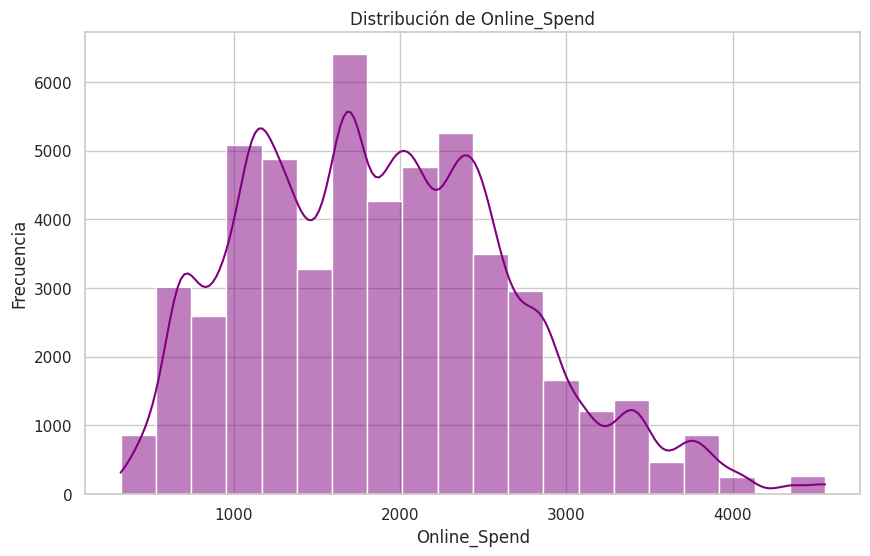

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para gráficos
sns.set(style="whitegrid")

# Histograma para 'Tenure_Months'
plt.figure(figsize=(10, 6))
sns.histplot(df.toPandas(), x='Tenure_Months', bins=20, kde=True, color='blue')
plt.title('Distribución de Tenure_Months')
plt.xlabel('Tenure_Months')
plt.ylabel('Frecuencia')
plt.show()

# Histograma para 'Quantity'
plt.figure(figsize=(10, 6))
sns.histplot(df.toPandas(), x='Quantity', bins=20, kde=True, color='green')
plt.title('Distribución de Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frecuencia')
plt.show()

# Histograma para 'Avg_Price'
plt.figure(figsize=(10, 6))
sns.histplot(df.toPandas(), x='Avg_Price', bins=20, kde=True, color='orange')
plt.title('Distribución de Avg_Price')
plt.xlabel('Avg_Price')
plt.ylabel('Frecuencia')
plt.show()

# Histograma para 'Offline_Spend'
plt.figure(figsize=(10, 6))
sns.histplot(df.toPandas(), x='Offline_Spend', bins=20, kde=True, color='red')
plt.title('Distribución de Offline_Spend')
plt.xlabel('Offline_Spend')
plt.ylabel('Frecuencia')
plt.show()

# Histograma para 'Online_Spend'
plt.figure(figsize=(10, 6))
sns.histplot(df.toPandas(), x='Online_Spend', bins=20, kde=True, color='purple')
plt.title('Distribución de Online_Spend')
plt.xlabel('Online_Spend')
plt.ylabel('Frecuencia')
plt.show()


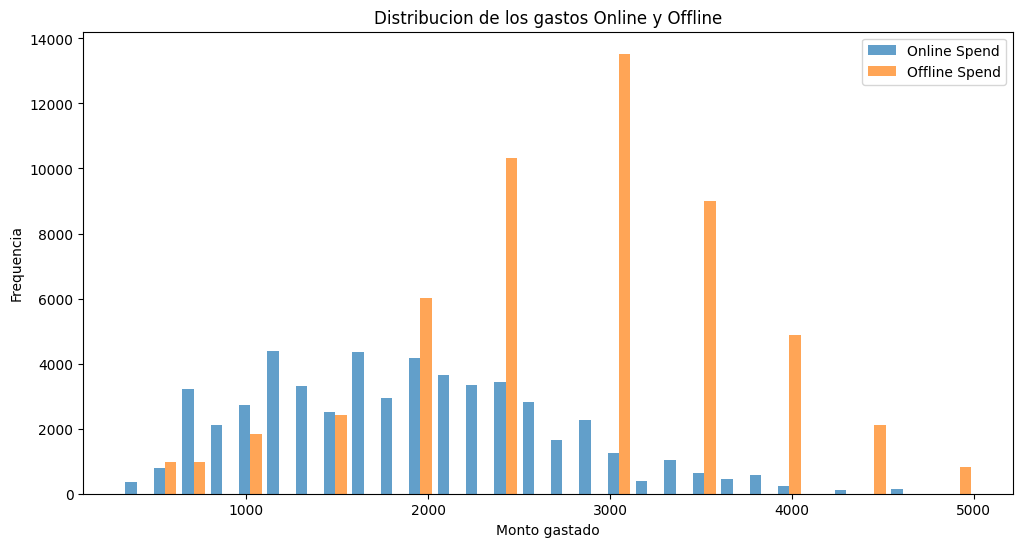

In [ ]:
import matplotlib.pyplot as plt

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Histograma de gastos online y offline
plt.hist([df.filter(df['Online_Spend'].isNotNull()).select('Online_Spend').toPandas()['Online_Spend'],
          df.filter(df['Offline_Spend'].isNotNull()).select('Offline_Spend').toPandas()['Offline_Spend']],
         bins=30, alpha=0.7, label=['Online Spend', 'Offline Spend'])

# Añadir etiquetas y título
plt.xlabel('Monto gastado')
plt.ylabel('Frequencia')
plt.title('Distribucion de los gastos Online y Offline')
plt.legend()

# Mostrar el gráfico
plt.show()


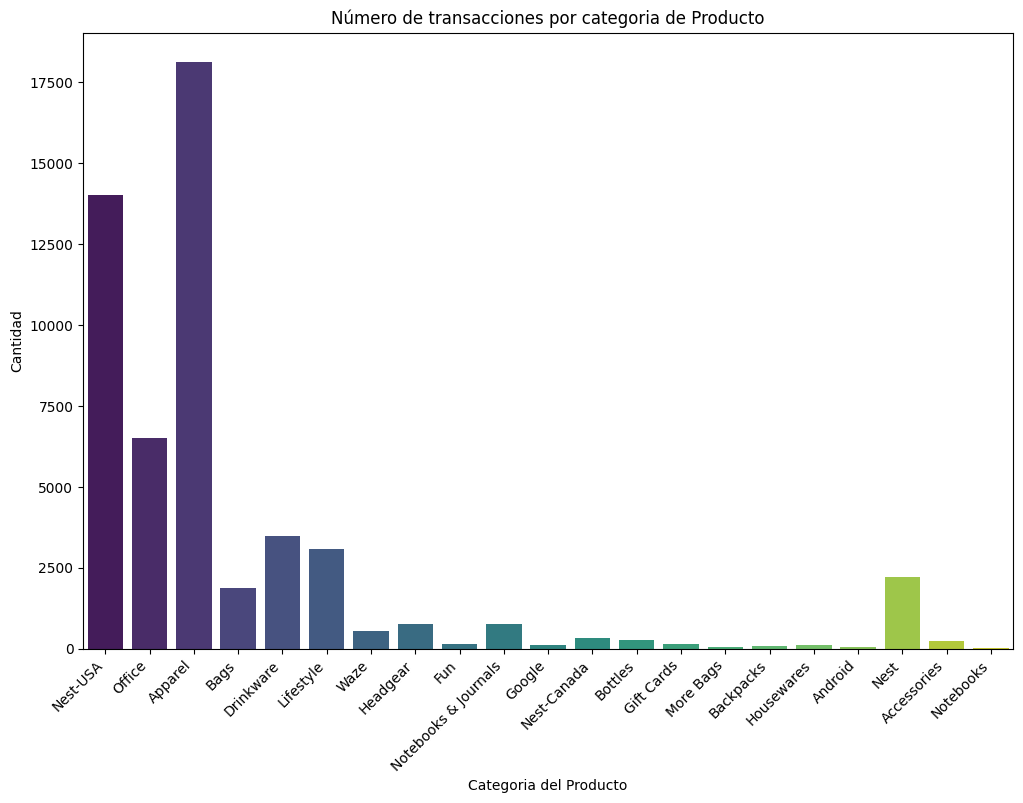

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Gráfico de barras para categorías de productos
sns.countplot(data=df.toPandas(), x='Product_Category', palette='viridis')

# Añadir etiquetas y título
plt.xlabel('Categoria del Producto')
plt.ylabel('Cantidad')
plt.title('Número de transacciones por categoria de Producto')

# Rotar etiquetas en el eje x para mayor claridad
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.show()


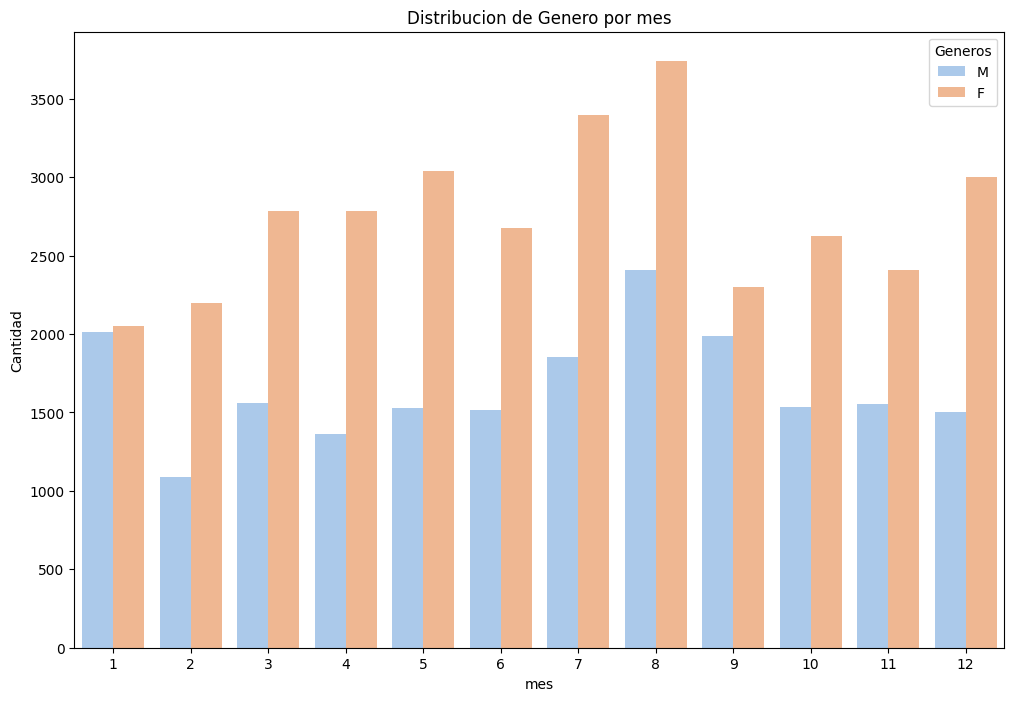

In [ ]:
#NUMERO DE TRANSACCIONES MENSUALES POR GENERO
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Gráfico de barras agrupadas para género y mes
sns.countplot(data=df.toPandas(), x='Month', hue='Gender', palette='pastel')

# Añadir etiquetas y título
plt.xlabel('mes')
plt.ylabel('Cantidad')
plt.title('Distribucion de Genero por mes')

# Personalizar la leyenda
plt.legend(title='Generos')

# Mostrar el gráfico
plt.show()


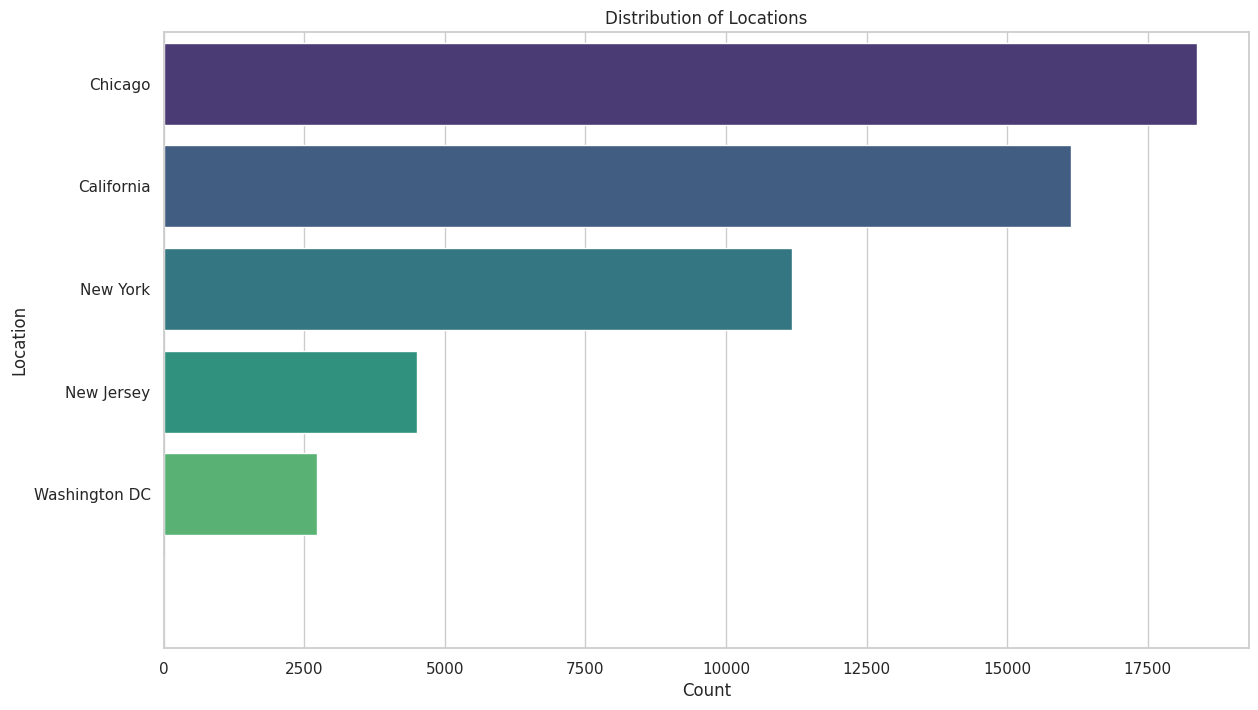

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el tamaño del gráfico
plt.figure(figsize=(14, 8))

# Gráfico de barras para la distribución de ubicaciones
sns.countplot(data=df.toPandas(), y='Location', palette='viridis', order=df.groupBy('Location').count().orderBy('count', ascending=False).toPandas()['Location'])

# Añadir etiquetas y título
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Distribution of Locations')

# Mostrar el gráfico
plt.show()


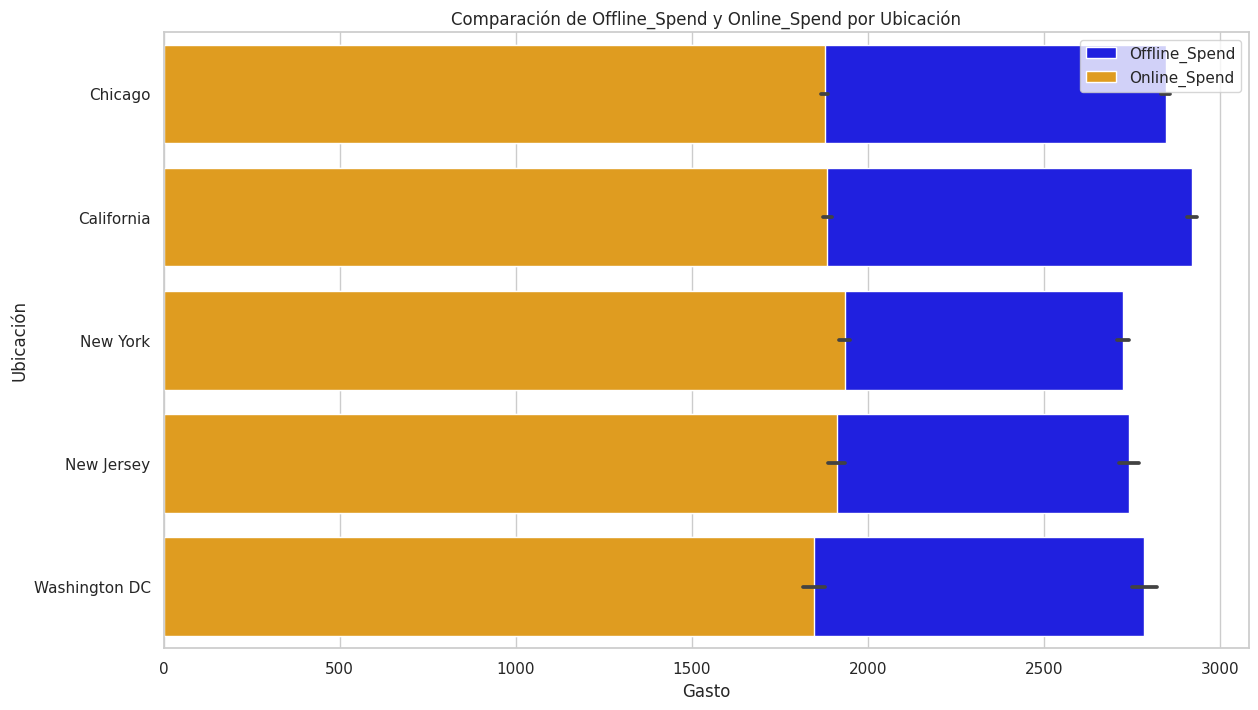

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el tamaño del gráfico
plt.figure(figsize=(14, 8))

# Crear un DataFrame en formato pandas para facilitar el manejo de datos
df_pandas = df.toPandas()

# Gráfico de barras apiladas para Location, comparando Offline_Spend y Online_Spend
sns.barplot(data=df_pandas, x='Offline_Spend', y='Location', color='blue', label='Offline_Spend')
sns.barplot(data=df_pandas, x='Online_Spend', y='Location', color='orange', label='Online_Spend')

# Añadir etiquetas y título
plt.xlabel('Gasto')
plt.ylabel('Ubicación')
plt.title('Comparación de Offline_Spend y Online_Spend por Ubicación')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/usr/local/lib/python3.10/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


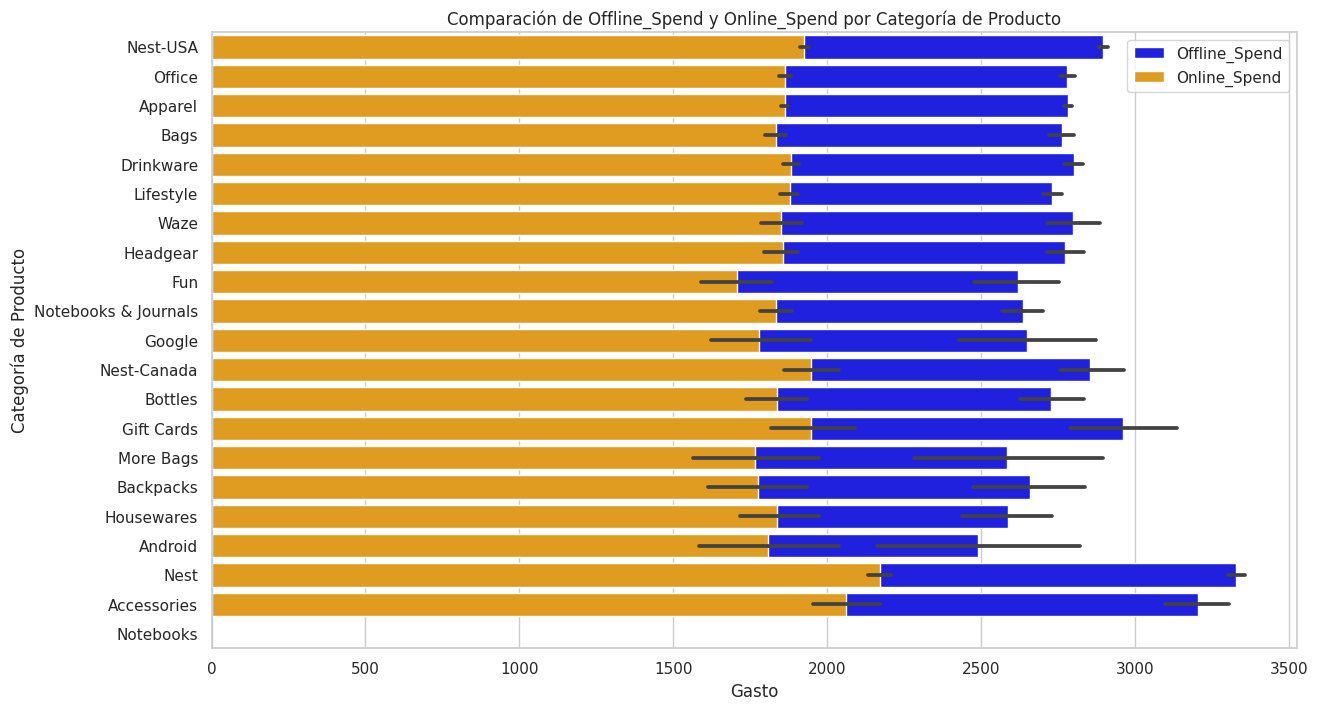

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el tamaño del gráfico
plt.figure(figsize=(14, 8))

# Crear un DataFrame en formato pandas para facilitar el manejo de datos
df_pandas = df.toPandas()

# Gráfico de barras apiladas para Product_Category, comparando Offline_Spend y Online_Spend
sns.barplot(data=df_pandas, x='Offline_Spend', y='Product_Category', color='blue', label='Offline_Spend')
sns.barplot(data=df_pandas, x='Online_Spend', y='Product_Category', color='orange', label='Online_Spend')

# Añadir etiquetas y título
plt.xlabel('Gasto')
plt.ylabel('Categoría de Producto')
plt.title('Comparación de Offline_Spend y Online_Spend por Categoría de Producto')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


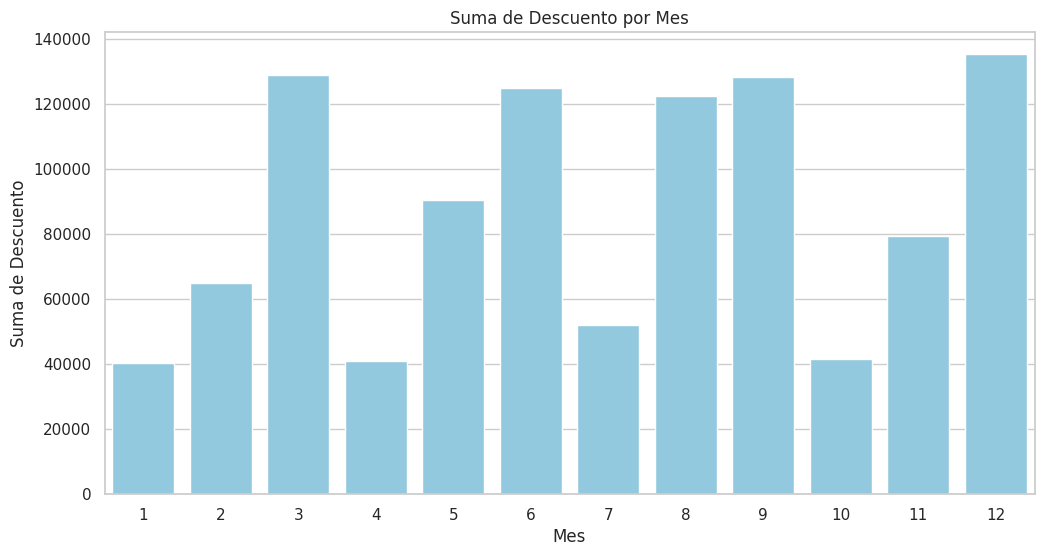

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Crear un DataFrame en formato pandas para facilitar el manejo de datos
df_pandas = df.toPandas()

# Calcular la suma de Discount_pct por mes
discount_sum_by_month = df_pandas.groupby('Month')['Discount_pct'].sum().reset_index()

# Gráfico de barras para la suma de Discount_pct por mes
sns.barplot(x='Month', y='Discount_pct', data=discount_sum_by_month, color='skyblue')

# Añadir etiquetas y título
plt.xlabel('Mes')
plt.ylabel('Suma de Descuento')
plt.title('Suma de Descuento por Mes')

# Mostrar el gráfico
plt.show()


PREDICCION DE GASTOS ONLINE

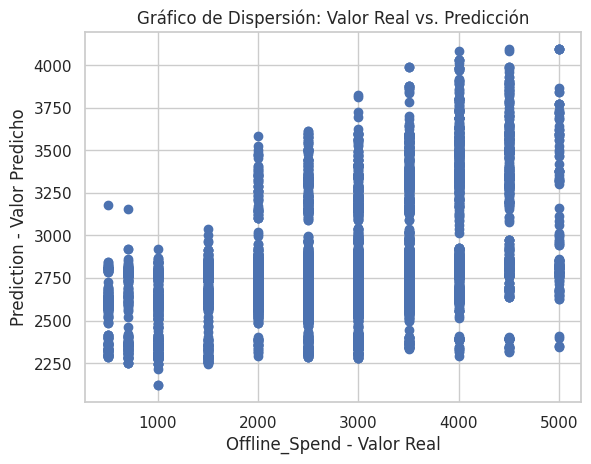

In [ ]:
import matplotlib.pyplot as plt

predictions_and_labels = predictions_reg.select("prediction", "Offline_Spend").toPandas()

plt.scatter(predictions_and_labels["Offline_Spend"], predictions_and_labels["prediction"])
plt.xlabel("Offline_Spend - Valor Real")
plt.ylabel("Prediction - Valor Predicho")
plt.title("Gráfico de Dispersión: Valor Real vs. Predicción")
plt.show()



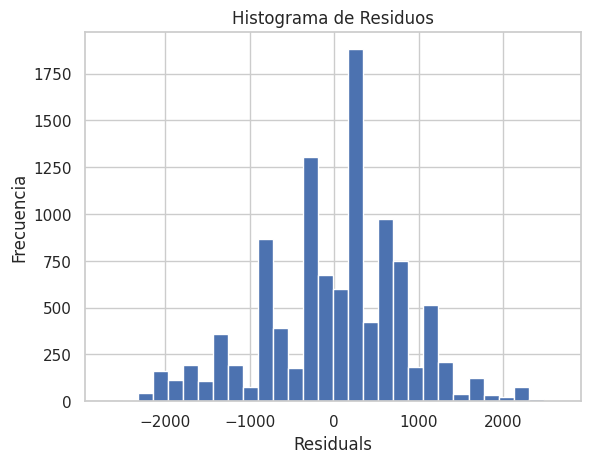

In [ ]:
residuals = predictions_reg.select("Offline_Spend", "prediction").withColumn("residual", predictions_reg["Offline_Spend"] - predictions_reg["prediction"]).toPandas()

plt.hist(residuals["residual"], bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frecuencia")
plt.title("Histograma de Residuos")
plt.show()


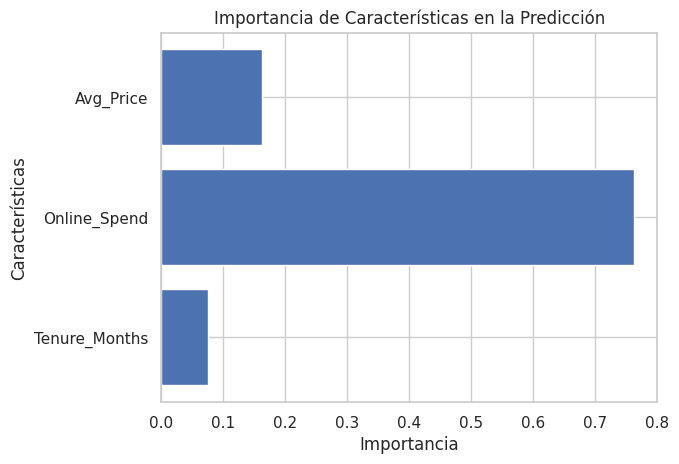

In [ ]:
importances = model_reg.featureImportances.toArray()
feature_names = feature_columns

plt.barh(feature_names, importances)
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de Características en la Predicción")
plt.show()


In [ ]:
#PRIMER INTENTO DE PREDICCION
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Crear un ensamblador de características
feature_columns = ['Tenure_Months', 'Online_Spend', 'Avg_Price']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid='keep')
df_reg = assembler.transform(df).dropna(subset=['Offline_Spend'])

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data_reg, test_data_reg = df_reg.randomSplit([0.8, 0.2], seed=42)

# Iniciando el modelo de regresión Random Forest
rf_reg = RandomForestRegressor(featuresCol='features', labelCol='Offline_Spend')

# Entrenar el modelo
model_reg = rf_reg.fit(train_data_reg)

# Realizar predicciones en el conjunto de prueba
predictions_reg = model_reg.transform(test_data_reg)

# Evaluar el rendimiento del modelo (RMSE y R cuadrado)
evaluator_reg = RegressionEvaluator(labelCol='Offline_Spend', predictionCol='prediction', metricName='rmse')
rmse = evaluator_reg.evaluate(predictions_reg)

# Calcular el coeficiente de determinación (R cuadrado)
evaluator_r2 = RegressionEvaluator(labelCol='Offline_Spend', predictionCol='prediction', metricName='r2')
r2 = evaluator_r2.evaluate(predictions_reg)

print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")
print(f"Coeficiente de Determinación (R cuadrado): {r2}")


Raíz del Error Cuadrático Medio (RMSE): 838.3269316410787
Coeficiente de Determinación (R cuadrado): 0.18555121462016677


In [ ]:
#SEGUNDO INTENTO DE PREDICCION
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Crear un ensamblador de características
feature_columns = ['Online_Spend']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid='keep')
df_reg = assembler.transform(df).dropna(subset=['Offline_Spend'])

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data_reg, test_data_reg = df_reg.randomSplit([0.8, 0.2], seed=42)

# Inicializar el modelo de regresión (Random Forest)
rf_reg = RandomForestRegressor(featuresCol='features', labelCol='Offline_Spend')

# Entrenar el modelo
model_reg = rf_reg.fit(train_data_reg)

# Realizar predicciones en el conjunto de prueba
predictions_reg = model_reg.transform(test_data_reg)

# Evaluar el rendimiento del modelo (RMSE y R cuadrado)
evaluator_reg = RegressionEvaluator(labelCol='Offline_Spend', predictionCol='prediction', metricName='rmse')
rmse = evaluator_reg.evaluate(predictions_reg)

# Calcular el coeficiente de determinación (R cuadrado)
evaluator_r2 = RegressionEvaluator(labelCol='Offline_Spend', predictionCol='prediction', metricName='r2')
r2 = evaluator_r2.evaluate(predictions_reg)

print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")
print(f"Coeficiente de Determinación (R cuadrado): {r2}")

Raíz del Error Cuadrático Medio (RMSE): 832.4782934883668
Coeficiente de Determinación (R cuadrado): 0.19687567511595117


USANDO REGRESION LINEAL

In [ ]:
#INTENTO N°1 USANDO REGRESION LINEAL
from pyspark.ml.regression import LinearRegression

# Crear un ensamblador de características
feature_columns = ['Tenure_Months', 'Online_Spend', 'Avg_Price']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid='keep')
df_reg_online = assembler.transform(df).dropna(subset=['Online_Spend'])

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data_online, test_data_online = df_reg_online.randomSplit([0.8, 0.2], seed=42)

# Inicializar el modelo de regresión lineal
lr_online = LinearRegression(featuresCol='features', labelCol='Online_Spend')

# Entrenar el modelo
model_lr_online = lr_online.fit(train_data_online)

# Realizar predicciones en el conjunto de prueba
predictions_lr_online = model_lr_online.transform(test_data_online)

# Evaluar el rendimiento del modelo
evaluator_lr_online = RegressionEvaluator(labelCol='Online_Spend', metricName='rmse')
rmse_lr_online = evaluator_lr_online.evaluate(predictions_lr_online)
print(f"Raíz del Error Cuadrático Medio (RMSE) para Gastos online: {rmse_lr_online}")

# Calcular el coeficiente de determinación (R cuadrado)
r2_lr_online = model_lr_online.summary.r2
print(f"Coeficiente de Determinación (R cuadrado) para Gastos online: {r2_lr_online}")


Raíz del Error Cuadrático Medio (RMSE) para Gastos online: 1.2319045308133206e-12
Coeficiente de Determinación (R cuadrado) para Gastos online: 1.0


In [ ]:
#REALIZANDO UNA VALIDACION CRUZADA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Crear el ensamblador de características
feature_columns = ['Tenure_Months', 'Online_Spend', 'Avg_Price']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid='keep')
df_reg = assembler.transform(df).dropna(subset=['Offline_Spend'])

# Inicializar el modelo de regresión lineal
lr_reg = LinearRegression(featuresCol='features', labelCol='Offline_Spend')

# Crear el evaluador de regresión
evaluator_reg = RegressionEvaluator(labelCol='Offline_Spend', metricName='rmse', predictionCol='prediction')

# Construir el grid de parámetros
param_grid = ParamGridBuilder() \
    .addGrid(lr_reg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Inicializar el validador cruzado
crossval = CrossValidator(estimator=lr_reg,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator_reg,
                          numFolds=3)  # Número de particiones

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data_reg, test_data_reg = df_reg.randomSplit([0.8, 0.2], seed=42)

# Ajustar el modelo utilizando el validador cruzado
cv_model = crossval.fit(train_data_reg)

# Realizar predicciones en el conjunto de prueba
predictions_reg = cv_model.transform(test_data_reg)

# Evaluar el rendimiento del modelo
rmse = evaluator_reg.evaluate(predictions_reg)
r2 = evaluator_reg.setMetricName('r2').evaluate(predictions_reg)  # Coeficiente de determinación
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")
print(f"Coeficiente de Determinación (R cuadrado): {r2}")


Raíz del Error Cuadrático Medio (RMSE): 873.9177186321145
Coeficiente de Determinación (R cuadrado): 0.11492915930915137


In [ ]:
#INTENTANDO LA VALIDACION CRUZADA EN EL MODELO RANDOM FOREST
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Crear el ensamblador de características
feature_columns = ['Tenure_Months', 'Online_Spend', 'Avg_Price']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid='keep')
df_reg = assembler.transform(df).dropna(subset=['Offline_Spend'])

# Inicializar el modelo de regresión (Bosque Aleatorio)
rf_reg = RandomForestRegressor(featuresCol='features', labelCol='Offline_Spend')

# Crear el evaluador de regresión
evaluator_reg_rmse = RegressionEvaluator(labelCol='Offline_Spend', metricName='rmse')
evaluator_reg_r2 = RegressionEvaluator(labelCol='Offline_Spend', metricName='r2')

# Construir el grid de parámetros
param_grid = ParamGridBuilder() \
    .addGrid(rf_reg.numTrees, [10, 20, 30, 50]) \
    .addGrid(rf_reg.maxDepth, [5, 10, 15, 20]) \
    .build()

# Inicializar el validador cruzado
crossval = CrossValidator(estimator=rf_reg,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator_reg_rmse,
                          numFolds=3)  # Número de particiones

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data_reg, test_data_reg = df_reg.randomSplit([0.8, 0.2], seed=42)

# Ajustar el modelo utilizando el validador cruzado
cv_model = crossval.fit(train_data_reg)

# Realizar predicciones en el conjunto de prueba
predictions_reg = cv_model.transform(test_data_reg)

# Evaluar el rendimiento del modelo (RMSE)
rmse = evaluator_reg_rmse.evaluate(predictions_reg)
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")

# Evaluar el rendimiento del modelo (R cuadrado)
r2 = evaluator_reg_r2.evaluate(predictions_reg)
print(f"Coeficiente de Determinación (R cuadrado): {r2}")



Raíz del Error Cuadrático Medio (RMSE): 683.2032537075239
Coeficiente de Determinación (R cuadrado): 0.45907532186338984


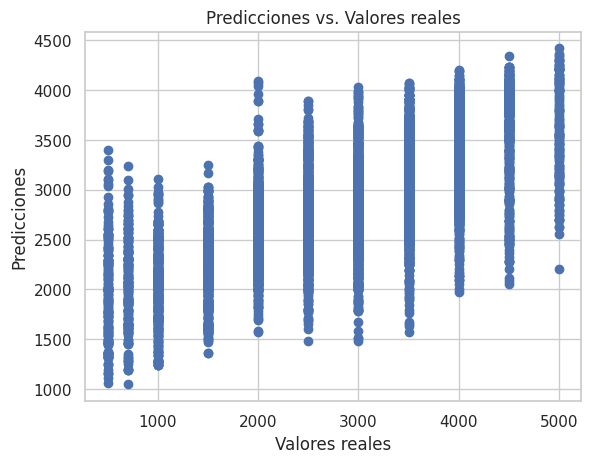

In [ ]:
import matplotlib.pyplot as plt

# Extraer las predicciones y las etiquetas reales
predictions = predictions_reg.select('prediction').rdd.flatMap(lambda x: x).collect()
labels = predictions_reg.select('Offline_Spend').rdd.flatMap(lambda x: x).collect()

# Crear el gráfico de dispersión
plt.scatter(labels, predictions)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores reales')
plt.show()


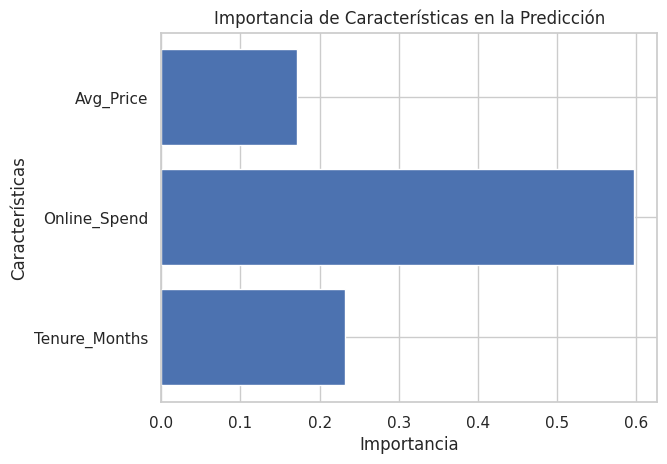

In [ ]:
importances = cv_model.bestModel.featureImportances.toArray()
feature_names = feature_columns

plt.barh(feature_names, importances)
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de Características en la Predicción')
plt.show()


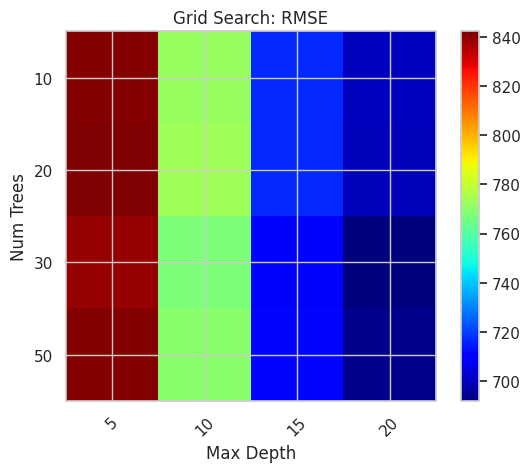

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


cv_metrics = cv_model.avgMetrics
num_trees_values = [10, 20, 30, 50]
max_depth_values = [5, 10, 15, 20]

plt.imshow(np.array(cv_metrics).reshape(len(num_trees_values), len(max_depth_values)),
           interpolation='nearest', cmap=plt.cm.jet)
plt.colorbar()
plt.xticks(np.arange(len(max_depth_values)), max_depth_values, rotation=45)
plt.yticks(np.arange(len(num_trees_values)), num_trees_values)
plt.xlabel('Max Depth')
plt.ylabel('Num Trees')
plt.title('Grid Search: RMSE')
plt.show()


In [ ]:
#INTENTANDO EN EL MODELO RANDOM FOREST NUEVAMENTE
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Crear el ensamblador de características
feature_columns = ['Tenure_Months', 'Online_Spend', 'Avg_Price']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid='keep')
df_reg = assembler.transform(df).dropna(subset=['Offline_Spend'])

# Inicializar el modelo de regresión (Bosque Aleatorio)
rf_reg = RandomForestRegressor(featuresCol='features', labelCol='Offline_Spend')

# Crear el evaluador de regresión
evaluator_reg_rmse = RegressionEvaluator(labelCol='Offline_Spend', metricName='rmse')
evaluator_reg_r2 = RegressionEvaluator(labelCol='Offline_Spend', metricName='r2')

# Construir el grid de parámetros
param_grid = ParamGridBuilder() \
    .addGrid(rf_reg.numTrees, [10, 20, 30, 50]) \
    .addGrid(rf_reg.maxDepth, [30]) \
    .build()

# Inicializar el validador cruzado
crossval = CrossValidator(estimator=rf_reg,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator_reg_rmse,
                          numFolds=3)  # Número de particiones

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data_reg, test_data_reg = df_reg.randomSplit([0.8, 0.2], seed=42)

# Ajustar el modelo utilizando el validador cruzado
cv_model = crossval.fit(train_data_reg)

# Realizar predicciones en el conjunto de prueba
predictions_reg = cv_model.transform(test_data_reg)

# Evaluar el rendimiento del modelo (RMSE)
rmse = evaluator_reg_rmse.evaluate(predictions_reg)
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")

# Evaluar el rendimiento del modelo (R cuadrado)
r2 = evaluator_reg_r2.evaluate(predictions_reg)
print(f"Coeficiente de Determinación (R cuadrado): {r2}")



Raíz del Error Cuadrático Medio (RMSE): 681.5051872250652
Coeficiente de Determinación (R cuadrado): 0.4617608611546551


In [ ]:
#PROBANDO EL MODELO GRADIENT - BOOSTED
!pip install xgboost
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Crear un ensamblador de características
feature_columns = ['Tenure_Months', 'Online_Spend', 'Avg_Price']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid='keep')
df_reg = assembler.transform(df).dropna(subset=['Offline_Spend'])

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data_reg, test_data_reg = df_reg.randomSplit([0.8, 0.2], seed=42)

# Inicializar el modelo de regresión (Gradient Boosted Trees)
gbt_reg = GBTRegressor(featuresCol='features', labelCol='Offline_Spend')

# Crear el pipeline
pipeline = Pipeline(stages=[assembler, gbt_reg])

# Ajustar y transformar los datos de entrenamiento
model_gbt = pipeline.fit(train_data_reg)

# Realizar predicciones en el conjunto de prueba
predictions_gbt = model_gbt.transform(test_data_reg)

# Evaluar el rendimiento del modelo (RMSE)
evaluator_gbt_rmse = RegressionEvaluator(labelCol='Offline_Spend', metricName='rmse')
rmse_gbt = evaluator_gbt_rmse.evaluate(predictions_gbt)
print(f"Raíz del Error Cuadrático Medio (RMSE) para Gradient Boosted Trees: {rmse_gbt}")

# Evaluar el rendimiento del modelo (R cuadrado)
evaluator_gbt_r2 = RegressionEvaluator(labelCol='Offline_Spend', metricName='r2')
r2_gbt = evaluator_gbt_r2.evaluate(predictions_gbt)
print(f"Coeficiente de Determinación (R cuadrado) para Gradient Boosted Trees: {r2_gbt}")

In [ ]:
#PROBANDO EL MODELO GRADIENT - BOOSTED
from pyspark.ml.regression import GBTRegressor

# Inicializar el modelo de regresión Gradient Boosted Trees
gbt_reg = GBTRegressor(featuresCol='features', labelCol='Offline_Spend')

# Construir el grid de parámetros
param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt_reg.maxDepth, [5, 10, 15]) \
    .addGrid(gbt_reg.maxIter, [10, 20, 30]) \
    .build()

# Inicializar el validador cruzado para GBT
crossval_gbt = CrossValidator(estimator=gbt_reg,
                               estimatorParamMaps=param_grid_gbt,
                               evaluator=evaluator_reg_rmse,
                               numFolds=3)

# Ajustar el modelo utilizando el validador cruzado para GBT
cv_model_gbt = crossval_gbt.fit(train_data_reg)

# Realizar predicciones en el conjunto de prueba
predictions_gbt = cv_model_gbt.transform(test_data_reg)

# Evaluar el rendimiento del modelo GBT (RMSE)
rmse_gbt = evaluator_reg_rmse.evaluate(predictions_gbt)
print(f"Raíz del Error Cuadrático Medio (RMSE) para Gradient Boosted Trees: {rmse_gbt}")

# Evaluar el rendimiento del modelo GBT (R cuadrado)
r2_gbt = evaluator_reg_r2.evaluate(predictions_gbt)
print(f"Coeficiente de Determinación (R cuadrado) para Gradient Boosted Trees: {r2_gbt}")


Raíz del Error Cuadrático Medio (RMSE) para Gradient Boosted Trees: 617.3543024647893
Coeficiente de Determinación (R cuadrado) para Gradient Boosted Trees: 0.558321863569456
